In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

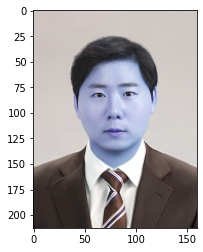

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

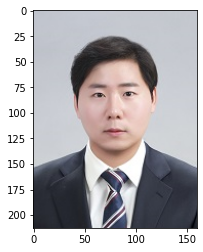

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
# sliding window를 사용해서 얼굴 위치 확인하기
detector_hog = dlib.get_frontal_face_detector()

# detector_hog로 bounding box를 추출
# dlib도 bgr이기 때문에 rbg로 변환시켜 준다.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # 이미지 피라미드 수 1로 설정
dlib_rects # 자동으로 얼굴 영역이 될 부분을 인식하여 좌표를 도출한다.

rectangles[[(38, 63) (113, 138)]]

rectangles[[(38, 63) (113, 138)]]


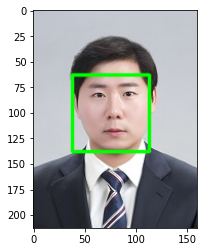

In [5]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
landmark_predictor

In [8]:
list_landmarks = []

# face landmark 찾기
# points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있음
# (x, y) 형태로 변환 -> 68개의 튜플을 가진 리스트로 만들어 준다.
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 이미지에서 찾아진 얼굴마다 68개의 튜플을 가진 리스트가 list_landmarks안에 들어간다.
# 현재 사진에서는 list_landmarks는 얼굴이 하나 이므로, 인덱스 0밖에 없다.
print(len(list_landmarks[0]))
print(list_landmarks[0])

68
[(43, 84), (44, 93), (45, 102), (48, 111), (51, 119), (56, 127), (63, 132), (71, 136), (80, 137), (89, 136), (97, 131), (104, 125), (109, 118), (112, 109), (114, 100), (115, 90), (115, 81), (52, 76), (56, 72), (62, 71), (68, 72), (74, 74), (82, 73), (88, 71), (94, 70), (100, 70), (104, 74), (78, 82), (79, 88), (79, 93), (79, 100), (73, 106), (76, 106), (79, 107), (82, 106), (85, 106), (59, 83), (62, 81), (66, 82), (69, 84), (66, 85), (62, 85), (88, 83), (91, 81), (95, 80), (98, 82), (95, 84), (92, 84), (69, 119), (73, 117), (76, 115), (79, 116), (82, 115), (85, 117), (90, 118), (86, 121), (82, 123), (79, 123), (76, 123), (73, 122), (70, 119), (76, 118), (79, 119), (82, 118), (88, 118), (82, 118), (79, 119), (76, 119)]


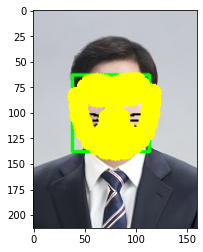

In [23]:
for landmark in list_landmarks:
    for point in landmark:
        # cv2.circle(img, center, radius, color[, thickness[, lineType[, shift]]]) 
        
        cv2.circle(img_show, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [13]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) 
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(79, 107)
(x,y) : (79,69)
(w,h) : (76,76)


In [17]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(76, 76, 3)


In [18]:
refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (41,69)


In [19]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (41,69)


In [20]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

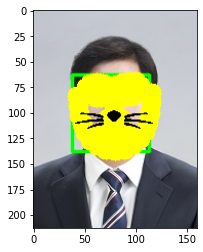

In [21]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

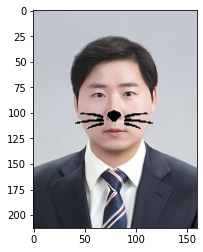

In [22]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

회고

지금까지 했던 프로젝트 중 제일 재미있었다. 더 많은 연습이 필요할 것 같다. 